
# Maestria en Explotacion de datos y Descubrimiento de conocimiento

## Aprendizaje Automatico

## Trabajo Practico N°1

### Grupo:

* Adrian Marino
* Alejandro Szpak
* Claudio Collado

In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
# sudo apt-get install sox

In [3]:
import warnings
warnings.filterwarnings('ignore')

In [70]:
import sys
sys.path.append('../src')

import itertools

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.ensemble        import RandomForestClassifier, \
                                    AdaBoostClassifier, \
                                    GradientBoostingClassifier

from sklearn.model_selection import train_test_split, RandomizedSearchCV, \
                                    LeaveOneGroupOut, StratifiedKFold, \
                                    cross_val_score, KFold

from sklearn.metrics import accuracy_score

from data   import Dataset
from metric import plot_confusion_matrix, missing_values_summary, \
                   set_summary, show_score, show_summary
from sound  import play, play_audio, get_functional_feats

## Funciones

In [5]:
def exclude_columns(df, columns): return df.drop(columns, axis=1)

#### 1. Cargamos el dataset que ya generamos en la notebook **generar-dataset**.

Este csv representa a todos los archivos de ambos dataset(speechs y songs). La notebook **generar-dataset** descarga ambos datasets y los descompromirlo. Luego recorrer una lista de paths, uno por cada archivo de audio y genera un csv donde las columnas se extraen de la siguiente forma:

* Se toman los features que estan definitos en el nombre del archivo separados por el caracter **-**.
* Se usando la libreria opensmile. Esta extrace features del archivo de audio.

In [6]:
dataset = pd.read_csv('dataset.csv')

In [7]:
dataset.head()

,Unnamed: 0,actor,file_path,modality,vocal_channel,emotion,emotional_intensity,statement,repetition,file,...,slopeUV0-500_sma3nz_amean,slopeUV500-1500_sma3nz_amean,spectralFluxUV_sma3nz_amean,loudnessPeaksPerSec,VoicedSegmentsPerSec,MeanVoicedSegmentLengthSec,StddevVoicedSegmentLengthSec,MeanUnvoicedSegmentLength,StddevUnvoicedSegmentLength,equivalentSoundLevel_dBp
0,0,23,./speech/Actor_23/03-01-04-02-01-01-23.wav,3,1,4,2,1,1,./speech/Actor_23/03-01-04-02-01-01-23.wav,...,0.044101,0.007548,0.015374,1.877934,1.425178,0.251667,0.247482,0.367143,0.419309,-39.951572
1,1,23,./speech/Actor_23/03-01-04-02-02-02-23.wav,3,1,4,2,2,2,./speech/Actor_23/03-01-04-02-02-02-23.wav,...,0.011092,0.008020,0.014090,1.694915,0.856531,0.357500,0.072241,0.634000,0.483429,-42.310856
2,2,23,./speech/Actor_23/03-01-06-02-01-02-23.wav,3,1,6,2,1,2,./speech/Actor_23/03-01-06-02-01-02-23.wav,...,0.101003,0.014311,0.014765,2.339181,0.593472,0.635000,0.335000,0.683333,0.449024,-34.312801
3,3,23,./speech/Actor_23/03-01-07-01-01-02-23.wav,3,1,7,1,1,2,./speech/Actor_23/03-01-07-01-01-02-23.wav,...,0.062009,0.011443,0.021647,2.528090,1.424501,0.180000,0.099800,0.416667,0.422834,-44.573288
4,4,23,./speech/Actor_23/03-01-03-01-01-02-23.wav,3,1,3,1,1,2,./speech/Actor_23/03-01-03-01-01-02-23.wav,...,0.032799,0.011666,0.009868,2.153846,0.625000,0.570000,0.320000,0.670000,0.452548,-36.173256


Audio de un speech:

In [8]:
play(dataset[dataset['vocal_channel'] == 1].iloc[0, :])

Audio Cantado:

In [9]:
play(dataset[dataset['vocal_channel'] == 2].iloc[0, :])

Quitamos columnas que no vamos usar como:

In [10]:
example_columns  = set(dataset.columns) - set([
    'Unnamed: 0',
    'file',
    'modality',
    'statement',
    'repetition',
    'start',
    'end'
])
target_column = 'emotion'

# Esta dos columnas se usan mas adelantes para hacer fold de los actores 
# y luego para agregar ruido a los audios.
special_columns = ['actor', 'file_path']

Luego codificamos **vocal_channel** como dummy y separamos en features de target:

In [11]:
dataset['vocal_channel'].value_counts()

1    1440
2    1012
Name: vocal_channel, dtype: int64

In [12]:
def features_target(df):
    df = df[example_columns]
    df['vocal_channel'] = pd.get_dummies(df['vocal_channel'])
    return exclude_columns(df, [target_column]),  df[[target_column]]

In [13]:
features, target = features_target(dataset)

In [14]:
features['vocal_channel'].value_counts()

1    1440
0    1012
Name: vocal_channel, dtype: int64

Analizamos si hay valores faltantes:

In [15]:
missing_values_summary(features)

Series([], dtype: float64)

Vemos que esta codificado el campo: 0 para speech y 1 para song.

Partimos en dev y test:

In [16]:
random_state = 1
test_size    = 0.3

In [17]:
X_dev, X_test, y_dev, y_test = train_test_split(
    features, 
    target, 
    test_size    = test_size, 
    stratify     = target, 
    random_state = random_state,
    shuffle      = True
)

A continuacion se muestra el porcentaje de ejemplos por clase y si hay valores faltantes:

In [18]:
set_summary(X_dev, y_dev)

- Features shape: (1716, 92)
- Target shape: (1716, 1)
- Target classes:
	- Clase '2': 15.33 %
	- Clase '3': 15.33 %
	- Clase '4': 15.33 %
	- Clase '5': 15.33 %
	- Clase '6': 15.33 %
	- Clase '7': 7.87 %
	- Clase '8': 7.81 %
- Valores faltantes en features: No hay valores faltantes!


In [19]:
set_summary(X_test, y_test)

- Features shape: (736, 92)
- Target shape: (736, 1)
- Target classes:
	- Clase '2': 15.35 %
	- Clase '3': 15.35 %
	- Clase '4': 15.35 %
	- Clase '5': 15.35 %
	- Clase '6': 15.35 %
	- Clase '8': 7.88 %
	- Clase '7': 7.74 %
- Valores faltantes en features: No hay valores faltantes!


#### 2. Ahora vamos a probar modelos con dos estrategias distintas de cross validation.

**Estrategia 1**: 12-fold cross validation armando los folds de forma aleatoria.

In [20]:
cv_strategy_1 = KFold(n_splits=12)

In [21]:
X_Dev_input = exclude_columns(X_dev, special_columns)

Random Forest:

In [22]:
%%time
show_score(RandomForestClassifier(), X_Dev_input, y_dev, cv_strategy_1)

Accuracy: 0.652 (0.026)
CPU times: user 54 ms, sys: 85 ms, total: 139 ms
Wall time: 1.43 s


Ada Boost:

In [23]:
%%time
show_score(AdaBoostClassifier(), X_Dev_input, y_dev, cv_strategy_1)

Accuracy: 0.363 (0.030)
CPU times: user 8.14 ms, sys: 4.72 ms, total: 12.9 ms
Wall time: 1.15 s


Gradient Boosting:

In [24]:
%%time
show_score(GradientBoostingClassifier(), X_Dev_input, y_dev, cv_strategy_1)

Accuracy: 0.650 (0.036)
CPU times: user 15.9 ms, sys: 3.16 ms, total: 19.1 ms
Wall time: 20.1 s


**Estrategia 2**: Leave-2-speakers out. Es decir, 12 folds conteniendo cada uno 2 actores distintos.

La siguiente funcion toma todos los posibles valores de la columna especificada en **input_column** los agrupa en grupos de tamaño **group_size** y luego agrega uni nueva columna (**target_column**) donde se especifica cada fila a que grupo pertenese:

In [25]:
def sample_groups(X, column, group_size):
    numbers = X[column].unique()
    sample  = np.random.choice(numbers, size=len(numbers), replace=False)
    
    return sample.reshape((int(len(numbers) / group_size), group_size))

def set_groups(X, input_column, group_size, target_column):
    tmp = X.copy()

    index = int(max(X[input_column].unique())) + 1
    for group in sample_groups(X, input_column, group_size):
        tmp[target_column] = tmp[input_column].apply(lambda x: index if x in group else x)
        index += 1

    return tmp

In [26]:
sample_groups(X_dev, 'actor', 2)

array([[18,  3],
       [24, 19],
       [ 7,  8],
       [15, 12],
       [17, 16],
       [ 9, 10],
       [21, 22],
       [ 1,  5],
       [11,  2],
       [ 6, 23],
       [ 4, 13],
       [20, 14]])

In [27]:
X_dev_tmp = set_groups(
    X_dev, 
    input_column  = 'actor', 
    group_size    = 2, 
    target_column = 'actor'
)
actors_fold_input  = exclude_columns(X_dev_tmp, special_columns)
actors_fold_groups = X_dev_tmp['actor']

Nos quedan 12 grupos de 2 actores cada uno:

In [28]:
len(actors_fold_groups.unique())

12

In [29]:
cv_strategy_2 = LeaveOneGroupOut()

Random Forest:

In [30]:
%%time
show_score(RandomForestClassifier(), actors_fold_input, y_dev, cv_strategy_2, actors_fold_groups)

Accuracy: 0.514 (0.080)
CPU times: user 13.1 ms, sys: 741 µs, total: 13.8 ms
Wall time: 831 ms


Ada Boost:

In [31]:
%%time
show_score(AdaBoostClassifier(), actors_fold_input, y_dev, cv_strategy_2, actors_fold_groups)

Accuracy: 0.370 (0.063)
CPU times: user 9.21 ms, sys: 3.27 ms, total: 12.5 ms
Wall time: 786 ms


Gradient Boosting:

In [32]:
%%time
show_score(GradientBoostingClassifier(), actors_fold_input, y_dev, cv_strategy_2, actors_fold_groups)

Accuracy: 0.546 (0.078)
CPU times: user 14.6 ms, sys: 1.22 ms, total: 15.8 ms
Wall time: 20.2 s


#### 3. Realizar la división de datos de la manera que considere más adecuada, teniendo en cuenta el análisis realizado en b), y comparar el desempeño de Random Forests y AdaBoost. Realizar una búsqueda de hiperparámetros para ambos modelos. Para esto, deberá elegirse una métrica de evaluación y justificar la elección. Reportar y analizar la matriz de confusión del mejor modelo, tanto para el caso de audios cantados como hablados.

In [33]:
def randomized_search(
    model, 
    params_grid, 
    cv, 
    X, 
    y,
    groups  = None, 
    scoring = 'accuracy', 
    n_jobs  = 24, 
    n_iter  = 50, 
    verbose = 1, 
    return_train_score = True
):
    rs = RandomizedSearchCV(
        model,
        params_grid, 
        n_jobs  = n_jobs, 
        scoring = scoring,
        cv      = cv,
        n_iter  = n_iter,
        verbose = verbose,
        return_train_score  = return_train_score
    )
    rs.fit(X, y, groups=groups)
    return rs

In [34]:
X_test_without_special_columns = exclude_columns(X_test, special_columns)

Random Forest:

In [35]:
%%time

rs = randomized_search(
    model       = RandomForestClassifier(), 
    X           = actors_fold_input, 
    y           = y_dev, 
    cv          = cv_strategy_2,
    groups      = actors_fold_groups,
    params_grid = {
        'criterion': ['gini','entropy'],
        'max_depth': list(range(1, 30)),
        'ccp_alpha': np.linspace(0, 0.5, 100)
    }, 
)
show_summary(rs.best_estimator_, X_test_without_special_columns, y_test)

Fitting 12 folds for each of 50 candidates, totalling 600 fits


[Parallel(n_jobs=24)]: Using backend LokyBackend with 24 concurrent workers.
[Parallel(n_jobs=24)]: Done   2 tasks      | elapsed:    0.8s
[Parallel(n_jobs=24)]: Done 152 tasks      | elapsed:    7.5s
[Parallel(n_jobs=24)]: Done 402 tasks      | elapsed:   19.1s
[Parallel(n_jobs=24)]: Done 600 out of 600 | elapsed:   26.0s finished


Accuracy: 41.304 %
CPU times: user 1.95 s, sys: 52.7 ms, total: 2.01 s
Wall time: 27.2 s


Ada Boost:

In [36]:
%%time

rs = randomized_search(
    model       = AdaBoostClassifier(), 
    X           = actors_fold_input, 
    y           = y_dev, 
    cv          = cv_strategy_2,
    groups      = actors_fold_groups,
    params_grid = {
        'n_estimators' : range(10, 20, 1),
        'learning_rate': np.arange(0, 1, 0.001)
    }
)
show_summary(rs.best_estimator_, X_test_without_special_columns, y_test)

Fitting 12 folds for each of 50 candidates, totalling 600 fits


[Parallel(n_jobs=24)]: Using backend LokyBackend with 24 concurrent workers.
[Parallel(n_jobs=24)]: Done   2 tasks      | elapsed:    0.2s
[Parallel(n_jobs=24)]: Done 152 tasks      | elapsed:    1.7s
[Parallel(n_jobs=24)]: Done 402 tasks      | elapsed:    3.9s
[Parallel(n_jobs=24)]: Done 600 out of 600 | elapsed:    5.8s finished


Accuracy: 39.266 %
CPU times: user 934 ms, sys: 37.4 ms, total: 972 ms
Wall time: 6.11 s


Gradient Boosting:

In [37]:
%%time

rs = randomized_search(
    model       = GradientBoostingClassifier(),  
    X           = actors_fold_input, 
    y           = y_dev, 
    cv          = cv_strategy_2,
    groups      = actors_fold_groups,
    params_grid = {
        'n_estimators' : range(10, 20, 1),
        'learning_rate': np.arange(0, 1, 0.001)
    } 
)
show_summary(rs.best_estimator_, X_test_without_special_columns, y_test)

Fitting 12 folds for each of 50 candidates, totalling 600 fits


[Parallel(n_jobs=24)]: Using backend LokyBackend with 24 concurrent workers.
[Parallel(n_jobs=24)]: Done   2 tasks      | elapsed:    3.7s
[Parallel(n_jobs=24)]: Done 152 tasks      | elapsed:   23.5s
[Parallel(n_jobs=24)]: Done 402 tasks      | elapsed:  1.0min
[Parallel(n_jobs=24)]: Done 600 out of 600 | elapsed:  1.5min finished


Accuracy: 59.647 %
CPU times: user 4.21 s, sys: 41.1 ms, total: 4.25 s
Wall time: 1min 34s


In [38]:
model = rs.best_estimator_

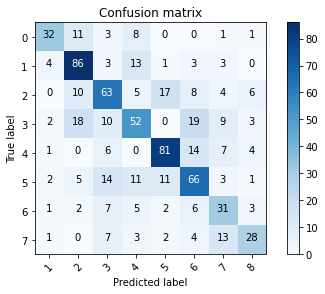

In [39]:
y_pred = model.predict(X_test_without_special_columns)
plot_confusion_matrix(y_test, y_pred)

In [40]:
man_actors   = [x for x in features['actor'].unique() if x % 2 == 0]
woman_actors = [x for x in features['actor'].unique() if x % 2 != 0]

In [41]:
def filter_set(X, y, column, values): return X[X[column].isin(values)], y[X[column].isin(values)]

speechs_features, speechs_y_true = filter_set(X_test_without_special_columns, y_test, 'vocal_channel', [0])
songs_features,   songs_y_true   = filter_set(X_test_without_special_columns, y_test, 'vocal_channel', [1])

speechs_features, speechs_y_true = filter_set(X_test_without_special_columns, y_test, 'vocal_channel', [0])
songs_features,   songs_y_true   = filter_set(X_test_without_special_columns, y_test, 'vocal_channel', [1])

man_features, man_y_true     = filter_set(X_test, y_test, 'actor', man_actors)
woman_features, woman_y_true = filter_set(X_test, y_test, 'actor', woman_actors)

man_features = exclude_columns(man_features, special_columns)
woman_features = exclude_columns(woman_features, special_columns)

Audios Cantados vs Hablados:

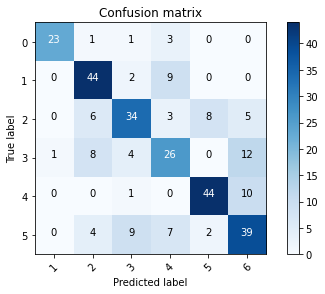

Accuracy: 68.627 %


In [42]:
y_pred = model.predict(speechs_features)

plot_confusion_matrix(speechs_y_true, y_pred)
show_summary(model, speechs_features, speechs_y_true)

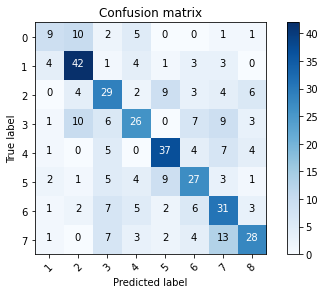

Accuracy: 53.256 %


In [43]:
y_pred = model.predict(songs_features)

plot_confusion_matrix(songs_y_true, y_pred)
show_summary(model, songs_features, songs_y_true)

Audios de  voces feneninas vs masculinas:

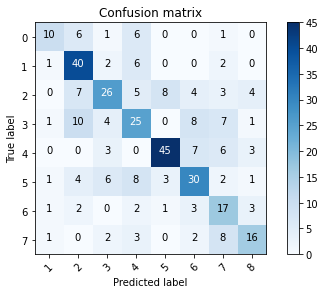

Accuracy: 56.793 %


In [44]:
y_pred = model.predict(woman_features)

plot_confusion_matrix(woman_y_true, y_pred)
show_summary(model, woman_features, woman_y_true)

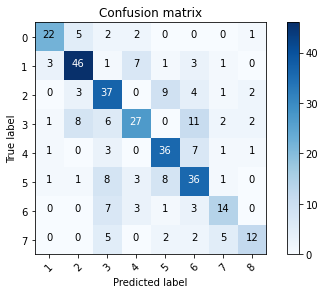

Accuracy: 62.500 %


In [45]:
y_pred = model.predict(man_features)

plot_confusion_matrix(man_y_true, y_pred)
show_summary(model, man_features, man_y_true)

#### 4. Evaluar la robustez del mejor modelo ante la presencia de ruido en los audios. Realizar una curva que muestre cómo varía una métrica de desempeño para distintas relaciones señal a ruido. El ruido utilizado puede ser sintético (gaussiano por ejemplo), o ruido ambiental. Algunas fuentes de ruido ambiental son:

A continuación definimos la funcion usada para extraer features del archivo de audio. Esta funcion agrega ruido al audio antes de extraer los features de manera que estos esten afectados por el ruido:

In [46]:
from librosa.feature import rms
import soundfile as sf
import uuid
import os
import pathlib

def create_dir(path):
    if not pathlib.Path(path).exists():
        os.mkdir(path)
    return path
            
def snr(audio, noise):
    return np.log10(np.quantile(rms(audio), 0.9) / np.quantile(rms(0.005 * noise), 0.9))

def append_noise(audio, level=1):
    noise = np.random.uniform(low=-level, high=level, size=(len(audio),))
    return snr(audio, noise) * noise + audio

def create_new_file_with_noise(path, level):
    audio, samplerate = sf.read(path)
    
    file_parts = path.split('/')
    
    destiny_path = create_dir('/'.join(file_parts[:-1]) + '/noisy')
    destiny_path += '/{}-{}'.format(uuid.uuid1(), file_parts[-1])

    sf.write(destiny_path, append_noise(audio, level), samplerate)
    return destiny_path

Comparemos un ejemplo sin ruido contra otro con cierto nivel de ruido:

In [47]:
example_path = X_test['file_path'].values[0]
play_audio(example_path)

In [48]:
noise_example_path = create_new_file_with_noise(example_path, level=10 ** -4)

print(noise_example_path)
play_audio(noise_example_path)

./speech/Actor_07/noisy/cb2b9462-d153-11eb-9d16-db86fe671bff-03-01-03-02-01-02-07.wav


Probamos la función que agregar el ruido t extrae los features del audio ya con ruido:

In [49]:
def feature_extraction_with_noise(file_path, level):
    if level > 0:
        file_path = create_new_file_with_noise(file_path, level)
    return get_functional_feats(file_path)

In [50]:
feature_extraction_with_noise(noise_example_path, level=0)

,file,start,end,F0semitoneFrom27.5Hz_sma3nz_amean,F0semitoneFrom27.5Hz_sma3nz_stddevNorm,F0semitoneFrom27.5Hz_sma3nz_percentile20.0,F0semitoneFrom27.5Hz_sma3nz_percentile50.0,F0semitoneFrom27.5Hz_sma3nz_percentile80.0,F0semitoneFrom27.5Hz_sma3nz_pctlrange0-2,F0semitoneFrom27.5Hz_sma3nz_meanRisingSlope,...,slopeUV0-500_sma3nz_amean,slopeUV500-1500_sma3nz_amean,spectralFluxUV_sma3nz_amean,loudnessPeaksPerSec,VoicedSegmentsPerSec,MeanVoicedSegmentLengthSec,StddevVoicedSegmentLengthSec,MeanUnvoicedSegmentLength,StddevUnvoicedSegmentLength,equivalentSoundLevel_dBp
0,./speech/Actor_07/noisy/cb2b9462-d153-11eb-9d1...,0 days,0 days 00:00:04.037354167,35.889244,0.147947,35.100948,36.967037,39.629745,4.528797,140.49733,...,0.008336,0.004428,0.046235,2.238806,1.763224,0.251429,0.173652,0.34,0.420079,-30.904844


In [51]:
feature_extraction_with_noise(noise_example_path, level=0.0005)

,file,start,end,F0semitoneFrom27.5Hz_sma3nz_amean,F0semitoneFrom27.5Hz_sma3nz_stddevNorm,F0semitoneFrom27.5Hz_sma3nz_percentile20.0,F0semitoneFrom27.5Hz_sma3nz_percentile50.0,F0semitoneFrom27.5Hz_sma3nz_percentile80.0,F0semitoneFrom27.5Hz_sma3nz_pctlrange0-2,F0semitoneFrom27.5Hz_sma3nz_meanRisingSlope,...,slopeUV0-500_sma3nz_amean,slopeUV500-1500_sma3nz_amean,spectralFluxUV_sma3nz_amean,loudnessPeaksPerSec,VoicedSegmentsPerSec,MeanVoicedSegmentLengthSec,StddevVoicedSegmentLengthSec,MeanUnvoicedSegmentLength,StddevUnvoicedSegmentLength,equivalentSoundLevel_dBp
0,./speech/Actor_07/noisy/noisy/cb40da2a-d153-11...,0 days,0 days 00:00:04.037354167,36.498455,0.127812,35.545551,37.01128,39.678986,4.133434,31.299637,...,0.010112,0.004347,0.060409,2.238806,1.763224,0.24,0.170378,0.353333,0.44199,-30.895361


Ahora vamos a correr el mejor modelo inyectando ruido al dataset de test para dsitintos niveles dde ruido:

In [52]:
def generate_noisy_features(example_paths, level=0):
    dataset = Dataset()
    examples = dataset.search_by_paths(
        paths = example_paths, 
        feature_extract_fn = lambda file_path: feature_extraction_with_noise(file_path, level)
    )
    X, y = features_target(examples)
    return exclude_columns(X, special_columns), y

In [53]:
test_example_paths = X_test['file_path'].unique()

In [54]:
accuracy = []
levels   = [0] + [10 ** -v for v in range(30, 0, -3)]
levels

[0, 1e-30, 1e-27, 1e-24, 1e-21, 1e-18, 1e-15, 1e-12, 1e-09, 1e-06, 0.001]

In [61]:
for level in levels:
    X_noise, _ = generate_noisy_features(test_example_paths, level)
    y_true     = y_test.iloc[X_noise.index.values, :]
    acc        = model.score(X_noise, y_true)
    accuracy.append(acc)
    print('SNR: {}, Accuracy: {:.2f} %'.format(level, acc * 100))    

  0%|          | 2/736 [00:00<01:05, 11.15it/s]

Dataset alredy downloaded!


  0%|          | 2/736 [00:00<01:09, 10.49it/s]

SNR: 0, Accuracy: 59.65 %
Dataset alredy downloaded!


 10%|█         | 74/736 [00:07<00:57, 11.58it/s]

Can't process ./song/Actor_24/03-02-01-01-01-01-24.wav!


 18%|█▊        | 131/736 [00:12<00:53, 11.32it/s]

Can't process ./speech/Actor_01/03-01-08-01-02-02-01.wav!


 49%|████▉     | 363/736 [00:35<00:31, 11.88it/s]

Can't process ./speech/Actor_05/03-01-02-01-02-02-05.wav!


 78%|███████▊  | 571/736 [00:56<00:15, 10.88it/s]

Can't process ./speech/Actor_20/03-01-03-01-02-01-20.wav!


  0%|          | 2/736 [00:00<01:09, 10.61it/s]

SNR: 1e-30, Accuracy: 19.54 %
Dataset alredy downloaded!


 10%|█         | 74/736 [00:07<00:55, 11.84it/s]

Can't process ./song/Actor_24/03-02-01-01-01-01-24.wav!


 18%|█▊        | 131/736 [00:12<00:52, 11.42it/s]

Can't process ./speech/Actor_01/03-01-08-01-02-02-01.wav!


 49%|████▉     | 364/736 [00:35<00:30, 12.09it/s]

Can't process ./speech/Actor_05/03-01-02-01-02-02-05.wav!


 78%|███████▊  | 571/736 [00:56<00:15, 10.74it/s]

Can't process ./speech/Actor_20/03-01-03-01-02-01-20.wav!


  0%|          | 2/736 [00:00<01:08, 10.68it/s]

SNR: 1e-27, Accuracy: 19.54 %
Dataset alredy downloaded!


 10%|█         | 74/736 [00:07<00:56, 11.63it/s]

Can't process ./song/Actor_24/03-02-01-01-01-01-24.wav!


 18%|█▊        | 131/736 [00:12<00:53, 11.29it/s]

Can't process ./speech/Actor_01/03-01-08-01-02-02-01.wav!


 49%|████▉     | 363/736 [00:35<00:31, 11.88it/s]

Can't process ./speech/Actor_05/03-01-02-01-02-02-05.wav!


 78%|███████▊  | 571/736 [00:56<00:15, 10.70it/s]

Can't process ./speech/Actor_20/03-01-03-01-02-01-20.wav!


  0%|          | 2/736 [00:00<01:09, 10.57it/s]

SNR: 1e-24, Accuracy: 19.54 %
Dataset alredy downloaded!


 10%|█         | 74/736 [00:07<00:56, 11.66it/s]

Can't process ./song/Actor_24/03-02-01-01-01-01-24.wav!


 18%|█▊        | 131/736 [00:12<00:53, 11.36it/s]

Can't process ./speech/Actor_01/03-01-08-01-02-02-01.wav!


 49%|████▉     | 363/736 [00:35<00:31, 11.90it/s]

Can't process ./speech/Actor_05/03-01-02-01-02-02-05.wav!


 77%|███████▋  | 570/736 [00:55<00:15, 10.95it/s]

Can't process ./speech/Actor_20/03-01-03-01-02-01-20.wav!


  0%|          | 2/736 [00:00<01:07, 10.93it/s]

SNR: 1e-21, Accuracy: 19.54 %
Dataset alredy downloaded!


 10%|█         | 74/736 [00:07<00:56, 11.77it/s]

Can't process ./song/Actor_24/03-02-01-01-01-01-24.wav!


 18%|█▊        | 131/736 [00:12<00:52, 11.42it/s]

Can't process ./speech/Actor_01/03-01-08-01-02-02-01.wav!


 49%|████▉     | 363/736 [00:35<00:31, 12.03it/s]

Can't process ./speech/Actor_05/03-01-02-01-02-02-05.wav!


 78%|███████▊  | 571/736 [00:56<00:15, 10.52it/s]

Can't process ./speech/Actor_20/03-01-03-01-02-01-20.wav!


  0%|          | 2/736 [00:00<01:08, 10.65it/s]

SNR: 1e-18, Accuracy: 19.54 %
Dataset alredy downloaded!


 10%|█         | 74/736 [00:07<00:56, 11.65it/s]

Can't process ./song/Actor_24/03-02-01-01-01-01-24.wav!


 18%|█▊        | 131/736 [00:12<00:53, 11.26it/s]

Can't process ./speech/Actor_01/03-01-08-01-02-02-01.wav!


 49%|████▉     | 363/736 [00:35<00:31, 11.79it/s]

Can't process ./speech/Actor_05/03-01-02-01-02-02-05.wav!


 78%|███████▊  | 571/736 [00:56<00:15, 10.86it/s]

Can't process ./speech/Actor_20/03-01-03-01-02-01-20.wav!


  0%|          | 2/736 [00:00<01:08, 10.72it/s]

SNR: 1e-15, Accuracy: 19.54 %
Dataset alredy downloaded!


 10%|█         | 74/736 [00:07<00:57, 11.58it/s]

Can't process ./song/Actor_24/03-02-01-01-01-01-24.wav!


 18%|█▊        | 131/736 [00:12<00:52, 11.42it/s]

Can't process ./speech/Actor_01/03-01-08-01-02-02-01.wav!


 49%|████▉     | 363/736 [00:35<00:31, 11.70it/s]

Can't process ./speech/Actor_05/03-01-02-01-02-02-05.wav!


 78%|███████▊  | 571/736 [00:56<00:15, 10.73it/s]

Can't process ./speech/Actor_20/03-01-03-01-02-01-20.wav!


  0%|          | 2/736 [00:00<01:09, 10.59it/s]

SNR: 1e-12, Accuracy: 19.54 %
Dataset alredy downloaded!


 10%|█         | 74/736 [00:07<00:56, 11.70it/s]

Can't process ./song/Actor_24/03-02-01-01-01-01-24.wav!


 18%|█▊        | 131/736 [00:12<00:53, 11.22it/s]

Can't process ./speech/Actor_01/03-01-08-01-02-02-01.wav!


 49%|████▉     | 363/736 [00:35<00:31, 11.82it/s]

Can't process ./speech/Actor_05/03-01-02-01-02-02-05.wav!


 78%|███████▊  | 571/736 [00:56<00:15, 10.81it/s]

Can't process ./speech/Actor_20/03-01-03-01-02-01-20.wav!


  0%|          | 2/736 [00:00<01:08, 10.74it/s]

SNR: 1e-09, Accuracy: 19.40 %
Dataset alredy downloaded!


 10%|█         | 74/736 [00:07<00:56, 11.67it/s]

Can't process ./song/Actor_24/03-02-01-01-01-01-24.wav!


 18%|█▊        | 131/736 [00:12<00:53, 11.29it/s]

Can't process ./speech/Actor_01/03-01-08-01-02-02-01.wav!


 49%|████▉     | 363/736 [00:35<00:31, 12.01it/s]

Can't process ./speech/Actor_05/03-01-02-01-02-02-05.wav!


 78%|███████▊  | 571/736 [00:56<00:15, 10.78it/s]

Can't process ./speech/Actor_20/03-01-03-01-02-01-20.wav!


  0%|          | 1/736 [00:00<01:16,  9.56it/s]

SNR: 1e-06, Accuracy: 18.99 %
Dataset alredy downloaded!


 10%|█         | 74/736 [00:07<00:57, 11.58it/s]

Can't process ./song/Actor_24/03-02-01-01-01-01-24.wav!


 18%|█▊        | 131/736 [00:12<00:54, 11.20it/s]

Can't process ./speech/Actor_01/03-01-08-01-02-02-01.wav!


 49%|████▉     | 363/736 [00:35<00:31, 11.88it/s]

Can't process ./speech/Actor_05/03-01-02-01-02-02-05.wav!


 78%|███████▊  | 571/736 [00:56<00:15, 10.78it/s]

Can't process ./speech/Actor_20/03-01-03-01-02-01-20.wav!


100%|██████████| 736/736 [01:13<00:00, 10.06it/s]

SNR: 0.001, Accuracy: 16.53 %


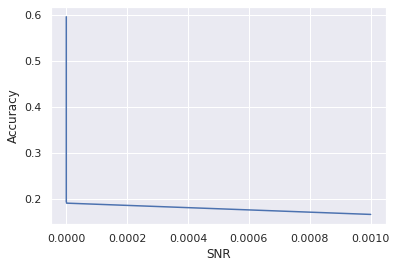

In [75]:
plt.xlabel('SNR')
plt.ylabel('Accuracy')
sns.lineplot(levels, accuracy)
plt.show()